Build feature and output arrays

In [1]:
import numpy as np
import pandas as pd
import json
import pandas as pd

# Listen für alle Daten
all_turbine_types = []
all_hub_heights = []
all_capacities = []
all_commissioning_dates = []
all_production_data = []

# JSON-Datei laden
with open(r"E:\MA_data\WPPs+production+reanalysis\WPPs+production+wind_new.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# Daten sammeln
for wpp in WPP_production_wind:
    all_turbine_types.append(str(wpp["Turbine"]))
    all_hub_heights.append(wpp["Hub_height"])
    all_capacities.append(wpp["Capacity"])
    all_commissioning_dates.append(f"{wpp['Commissioning_date']}/06" if isinstance(wpp["Commissioning_date"], str) and "/" not in wpp["Commissioning_date"] else wpp["Commissioning_date"])
    all_production_data.append(wpp["Production"])

# Alle Werte auf zwei Nachkommastellen runden
all_hub_heights = np.round(all_hub_heights, decimals=2)
all_capacities = np.round(all_capacities, decimals=2)

# NaN-Werte in Turbinentypen durch eindeutige Namen ersetzen
nan_counter = 1
for idx, turbine in enumerate(all_turbine_types):
    if pd.isna(turbine):
        all_turbine_types[idx] = f"nan{nan_counter}"
        nan_counter += 1

# convert E92/2350 format to E-92/2350 format
all_turbine_types = [f"E-{turbine[1:]}" if turbine.startswith("E") and not turbine.startswith("E-") else turbine for turbine in all_turbine_types]

# In datetime konvertieren
standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

# Berechnung des Alters
current_date = pd.Timestamp("2024-12-01")
ages = current_date.year * 12 + current_date.month - (standardised_dates.year * 12 + standardised_dates.month)

# Kombinierte Features und Outputs erstellen
combined_features_raw = []
output_raw = []

# Daten in Feature-Arrays konvertieren
for idx, production_data in enumerate(all_production_data):
    num_rows = len(production_data)

    # Wiederholungen für allgemeine Features
    turbine_type_repeated = np.full((num_rows, 1), all_turbine_types[idx])
    hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
    capacity_repeated = np.full((num_rows, 1), all_capacities[idx])
    age_repeated = np.full((num_rows, 1), ages[idx])

    # Extrahiere Produktionswerte und Windgeschwindigkeiten
    production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1) / all_capacities[idx]
    wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

    wind_speeds = np.round(wind_speeds, decimals=2)


    # Kombinieren in DataFrame, da ohne dtype-Konvertierung möglich (bei numpy arrays muss niedrigster gemeinsamer Datentyp gewählt werden, was string wäre wegen turbine_type_repeated)
    combined_chunk = pd.concat([
        pd.DataFrame(turbine_type_repeated, columns=["Turbine_Type"]),
        pd.DataFrame(hub_height_repeated, columns=["Hub_Height"]),
        pd.DataFrame(capacity_repeated, columns=["Capacity"]),
        pd.DataFrame(age_repeated, columns=["Age"]),
        pd.DataFrame(wind_speeds, columns=["Wind_Speed"])
    ], axis=1)

    # Füge die Daten hinzu
    combined_features_raw.append(combined_chunk)
    output_raw.append(production_values)

unique_turbine_types_real_data = np.unique(all_turbine_types)

# Kombinieren aller Datensätze in einem großen Array
combined_features_raw = np.vstack(combined_features_raw)
output_raw = np.vstack(output_raw)
output_raw = np.round(output_raw, decimals=2)

<h1>Load reforecast data

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import json
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torch


# Dataset-Klasse für PyTorch
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


input_dir = r"E:\MA_data\WPPs+production+reforecast"
dataset_lead_times = {}

for file in os.listdir(input_dir):
    file_path = os.path.join(input_dir, file)
    if os.path.isfile(file_path):  # Ensure it's a file (not a folder)
        lead_time = int(file.split("_")[-1].replace(".json", ""))
        with open(file_path, "r", encoding="utf-8") as file:
            forecast_data = json.load(file)

    print(f"Processing lead time: {lead_time}")

    all_turbine_types = []
    all_hub_heights = []
    all_capacities = []
    all_commissioning_dates = []
    all_production_data = []

    for unique_key, wpp in forecast_data.items():
        all_turbine_types.append(str(wpp["Turbine"]))
        all_hub_heights.append(wpp["Hub_height"])
        all_capacities.append(wpp["Capacity"])
        all_commissioning_dates.append(f"{wpp['Commissioning_date']}/06" if isinstance(wpp["Commissioning_date"], str) and "/" not in wpp["Commissioning_date"] else wpp["Commissioning_date"])
        all_production_data.append(wpp["Time Series"])

    # convert E92/2350 format to E-92/2350 format
    all_turbine_types = [f"E-{turbine[1:]}" if turbine.startswith("E") and not turbine.startswith("E-") else turbine for turbine in all_turbine_types]

    # convert to datetime
    standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

    # calculate age
    ref_date = pd.Timestamp("2024-12-01")
    ages = ref_date.year * 12 + ref_date.month - (standardised_dates.year * 12 + standardised_dates.month)

    # create combined features and output lists
    combined_features_raw = []
    output_raw = []
    
    # convert data in feature arrays
    for idx, production_data in enumerate(all_production_data):
        num_rows = len(production_data)

        # Repetitions for common features
        turbine_type_repeated = np.full((num_rows, 1), all_turbine_types[idx])
        hub_height_repeated = np.full((num_rows, 1), float(all_hub_heights[idx]))
        capacity_repeated = np.full((num_rows, 1), all_capacities[idx])
        age_repeated = np.full((num_rows, 1), ages[idx])

        # Extract production values and wind speeds
        production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1) / all_capacities[idx]
        wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

        # Kombinieren in DataFrame, da ohne dtype-Konvertierung möglich (bei numpy arrays muss niedrigster gemeinsamer Datentyp gewählt werden, was string wäre wegen turbine_type_repeated)
        combined_chunk = pd.concat([
            pd.DataFrame(turbine_type_repeated, columns=["Turbine_Type"]),
            pd.DataFrame(hub_height_repeated, columns=["Hub_Height"]),
            pd.DataFrame(capacity_repeated, columns=["Capacity"]),
            pd.DataFrame(age_repeated, columns=["Age"]),
            pd.DataFrame(wind_speeds, columns=["Wind_Speed"])
        ], axis=1)

        # add the data
        combined_features_raw.append(combined_chunk)
        output_raw.append(production_values)

    # Kombinieren aller Datensätze in einem großen Array
    combined_features = np.vstack(combined_features_raw)
    output = np.vstack(output_raw)
    output = np.round(output, decimals=4)

    # Interpolate missing values (linear interpolation) in pandas
    wind_speed_series = pd.Series(combined_features[:, -1])
    wind_speed_series = wind_speed_series.infer_objects(copy=False)
    wind_speed_series.interpolate(method='linear', inplace=True)
    wind_speed_series.bfill(inplace=True) # without this, errors can't be calculated for lead times with nan values
    combined_features[:, -1] = wind_speed_series.to_numpy()

    # Convert to Dataset
    dataset_lead_times[lead_time] = (combined_features, output)


Processing lead time: 0
Processing lead time: 102
Processing lead time: 105
Processing lead time: 108
Processing lead time: 111
Processing lead time: 114
Processing lead time: 117
Processing lead time: 12
Processing lead time: 120
Processing lead time: 123
Processing lead time: 126
Processing lead time: 129
Processing lead time: 132
Processing lead time: 135
Processing lead time: 138
Processing lead time: 141
Processing lead time: 144
Processing lead time: 15
Processing lead time: 18
Processing lead time: 21
Processing lead time: 24
Processing lead time: 27
Processing lead time: 3
Processing lead time: 30
Processing lead time: 33
Processing lead time: 36
Processing lead time: 39
Processing lead time: 42
Processing lead time: 45
Processing lead time: 48
Processing lead time: 51
Processing lead time: 54
Processing lead time: 57
Processing lead time: 6
Processing lead time: 60
Processing lead time: 63
Processing lead time: 66
Processing lead time: 69
Processing lead time: 72
Processing le

<h1>1. All power curves from The Wind Power that are available

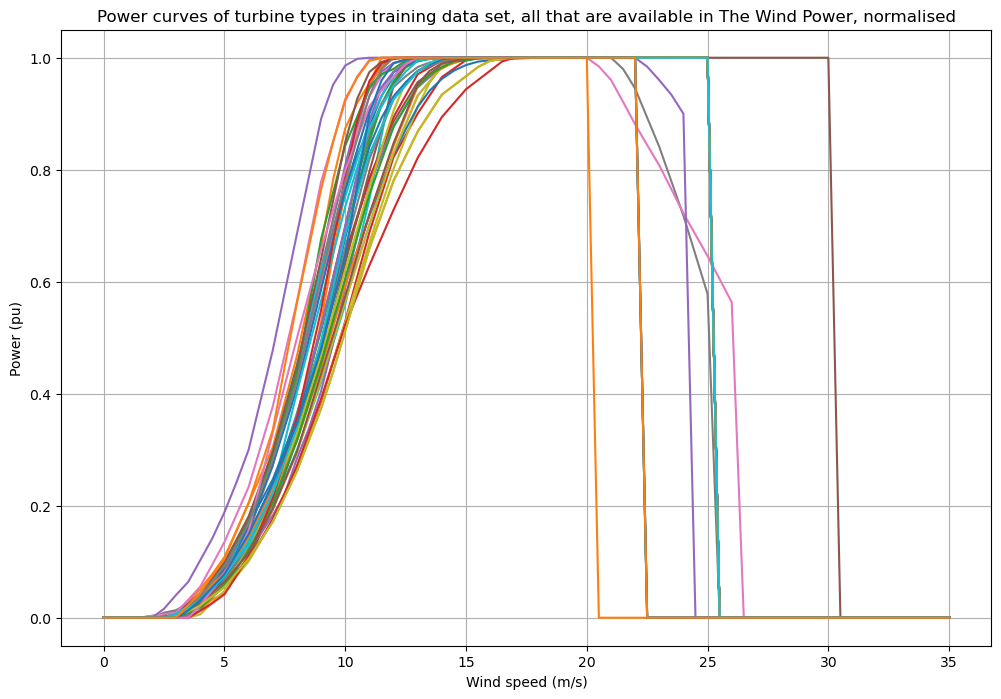

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



file_path_json = r"../data/synthetic,power_curves/power_curves.json"

with open(file_path_json, 'r', encoding='utf-16') as file:
    # Zeilenweise die Inhalte als Python-Listen parsen
    data_raw = [eval(line.strip()) for line in file]

# Extrahieren von wind_speed und power
wind_speeds_extracted = [float(item[0]) for item in data_raw]
powers_extracted = [item[1] for item in data_raw]



# assignment of power curve to turbine type
file_path_excel = r"../data/synthetic,power_curves/turbine_data.xlsx"
excel_data = pd.read_excel(file_path_excel, sheet_name='Turbine Types')

# Create a mask for non-empty values in the "The Wind Power" column
power_curve_available = excel_data['The Wind Power'].notna()

# Extract the turbine types with power curves in The Wind Power
turbine_types_with_power_curve = np.array(excel_data['Turbine Types'][power_curve_available])



# Extraction of the power curves
power_curves_individual = []
j = 0
i = 0
while j < len(wind_speeds_extracted):
    if wind_speeds_extracted[j] == 0:
        power_curves_individual.append([[], []])
        i += 1
    power_curves_individual[i-1][0].append(wind_speeds_extracted[j])
    power_curves_individual[i-1][1].append(powers_extracted[j])
    j += 1

# Default power curve is that of SWT-3.6-107
for i in range(len(turbine_types_with_power_curve)):
    if turbine_types_with_power_curve[i] == 'SWT-3.6-107':
        default_power_curve = power_curves_individual[i]

# Plot of the power curves
plt.figure(figsize=(12, 8))
for i, power_curve in enumerate(power_curves_individual):
    plt.plot(np.array(power_curve[0]), np.array(power_curve[1]) / max(power_curve[1]), label=turbine_types_with_power_curve[i])

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (pu)')
plt.title('Power curves of turbine types in training data set, all that are available in The Wind Power, normalised')
#plt.legend()
plt.grid(True)
plt.show()

Forecasting with reanalysis data

In [ ]:
from scipy.interpolate import interp1d


turbine_types = combined_features_raw[:, 0]
wind_speeds_data = combined_features_raw[:, -1]
capacities = combined_features_raw[:, -3]

prediction_1_reanalysis = []

# Iteration über alle Datenpunkte
for i, (turbine_type, wind_speed, capacity) in enumerate(zip(turbine_types, wind_speeds_data, capacities)):

    if turbine_type in turbine_types_with_power_curve:
        power_curve = power_curves_individual[list(turbine_types_with_power_curve).index(turbine_type)]
        interpolation_function = interp1d(
            np.array(power_curve[0]),
            np.array(power_curve[1]) / max(power_curve[1]),
            kind='cubic',
            fill_value=0 # set values outside the range to 0
        )
    else:
        interpolation_function = interp1d(
            np.array(default_power_curve[0]),
            np.array(default_power_curve[1]) / max(default_power_curve[1]),
            kind='cubic',
            fill_value=0 # set values outside the range to 0
        )
    
    # Vorhergesagten Wert berechnen
    prediction_1_reanalysis.append(interpolation_function(wind_speed))

prediction_1_reanalysis = np.array(prediction_1_reanalysis)

Forecasting with reforecast data

In [ ]:
prediction_1_reforecast = {}

for key, (combined_features, output) in dataset_lead_times.items():
    lead_time = key
    print(f"Forecasting for lead time {lead_time}")
    
    turbine_types = combined_features[:, 0]
    wind_speeds_data = combined_features[:, -1]
    capacities = combined_features[:, -3]

    prediction_1_lead_time = []

    # Iteration über alle Datenpunkte
    for i, (turbine_type, wind_speed, capacity) in enumerate(zip(turbine_types, wind_speeds_data, capacities)):

        if turbine_type in turbine_types_with_power_curve:
            power_curve = power_curves_individual[list(turbine_types_with_power_curve).index(turbine_type)]
            interpolation_function = interp1d(
                np.array(power_curve[0]),
                np.array(power_curve[1]) / max(power_curve[1]),
                kind='cubic',
                bounds_error=False,
                fill_value=0 # set values outside the range to 0
            )
        else:
            interpolation_function = interp1d(
                np.array(default_power_curve[0]),
                np.array(default_power_curve[1]) / max(default_power_curve[1]),
                kind='cubic',
                bounds_error=False,
                fill_value=0 # set values outside the range to 0
            )
        
        # Vorhergesagten Wert berechnen
        prediction_1_lead_time.append(interpolation_function(wind_speed))

    prediction_1_lead_time = np.array(prediction_1_lead_time)

    prediction_1_reforecast[lead_time] = prediction_1_lead_time

Forecasting for lead time 0
Forecasting for lead time 102
Forecasting for lead time 105
Forecasting for lead time 108
Forecasting for lead time 111
Forecasting for lead time 114
Forecasting for lead time 117
Forecasting for lead time 12
Forecasting for lead time 120
Forecasting for lead time 123
Forecasting for lead time 126
Forecasting for lead time 129
Forecasting for lead time 132
Forecasting for lead time 135
Forecasting for lead time 138
Forecasting for lead time 141
Forecasting for lead time 144
Forecasting for lead time 15
Forecasting for lead time 18
Forecasting for lead time 21
Forecasting for lead time 24
Forecasting for lead time 27
Forecasting for lead time 3
Forecasting for lead time 30
Forecasting for lead time 33
Forecasting for lead time 36
Forecasting for lead time 39
Forecasting for lead time 42
Forecasting for lead time 45
Forecasting for lead time 48
Forecasting for lead time 51
Forecasting for lead time 54
Forecasting for lead time 57
Forecasting for lead time 6
Fo

<h1>2. One representative power curve (SWT-3.6-107)

C:\Users\alexa\AppData\Local\Temp\ipykernel_26316\1022022850.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


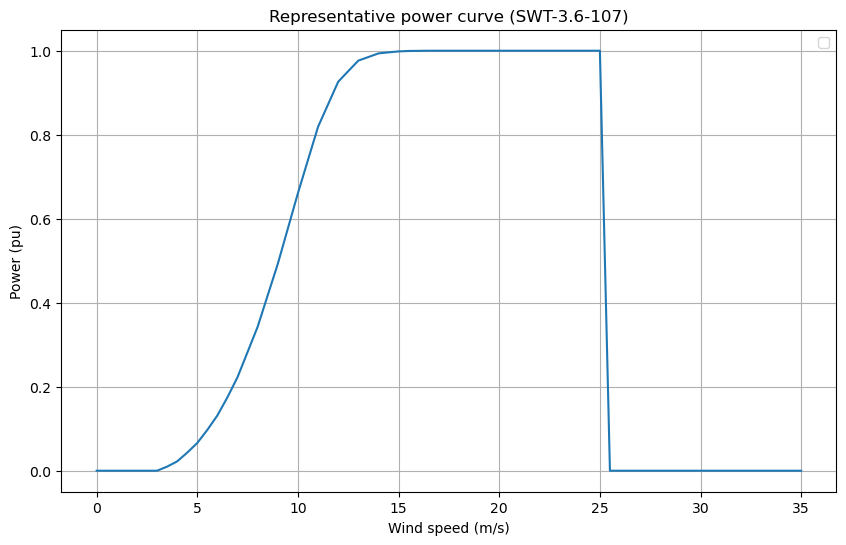

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Plot der diskreten und interpolierten Power Curve
plt.figure(figsize=(10, 6))
plt.plot(np.array(default_power_curve[0]), np.array(default_power_curve[1]) / max(default_power_curve[1]))
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (pu)')
plt.title('Representative power curve (SWT-3.6-107)')
plt.legend()
plt.grid(True)
plt.show()

Forecasting with reanalysis data

In [3]:
from scipy.interpolate import interp1d
import numpy as np

# Erstelle die Interpolationsfunktion
interpolation_function = interp1d(
    np.array(default_power_curve[0]),
    np.array(default_power_curve[1]) / max(default_power_curve[1]),
    kind='cubic',
    bounds_error=False,
    fill_value=0 # set values outside the range to 0
)

# Ensure wind_speeds_data is a numeric array: convert float elements to np.float64 elements
prediction_2_reanalysis = np.array(interpolation_function(combined_features_raw[:, -1].astype(float)))

TypeError: list indices must be integers or slices, not tuple

Forecasting with reforecast data

In [5]:
from scipy.interpolate import interp1d

prediction_2_reforecast = {}

for key, (combined_features, output) in dataset_lead_times.items():
    lead_time = key
    print(f"Forecasting for lead time {lead_time}")

    # Erstelle die Interpolationsfunktion
    interpolation_function = interp1d(
        np.array(default_power_curve[0]),
        np.array(default_power_curve[1]) / max(default_power_curve[1]),
        kind='cubic',
        bounds_error=False,
        fill_value=0 # set values outside the range to 0
    )

    # Ensure wind_speeds_data is a numeric array: convert float elements to np.float64 elements
    prediction_2_reforecast[lead_time] = np.array(interpolation_function(combined_features[:, -1].astype(float)))

Forecasting for lead time 0
Forecasting for lead time 102
Forecasting for lead time 105
Forecasting for lead time 108
Forecasting for lead time 111
Forecasting for lead time 114
Forecasting for lead time 117
Forecasting for lead time 12
Forecasting for lead time 120
Forecasting for lead time 123
Forecasting for lead time 126
Forecasting for lead time 129
Forecasting for lead time 132
Forecasting for lead time 135
Forecasting for lead time 138
Forecasting for lead time 141
Forecasting for lead time 144
Forecasting for lead time 15
Forecasting for lead time 18
Forecasting for lead time 21
Forecasting for lead time 24
Forecasting for lead time 27
Forecasting for lead time 3
Forecasting for lead time 30
Forecasting for lead time 33
Forecasting for lead time 36
Forecasting for lead time 39
Forecasting for lead time 42
Forecasting for lead time 45
Forecasting for lead time 48
Forecasting for lead time 51
Forecasting for lead time 54
Forecasting for lead time 57
Forecasting for lead time 6
Fo

<h1>3. Power curves from windpowerlib with a default turbine where no power curve available

c:\Users\alexa\anaconda3\envs\webapp_env_conda\Lib\site-packages\windpowerlib\data.py:103: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(False)


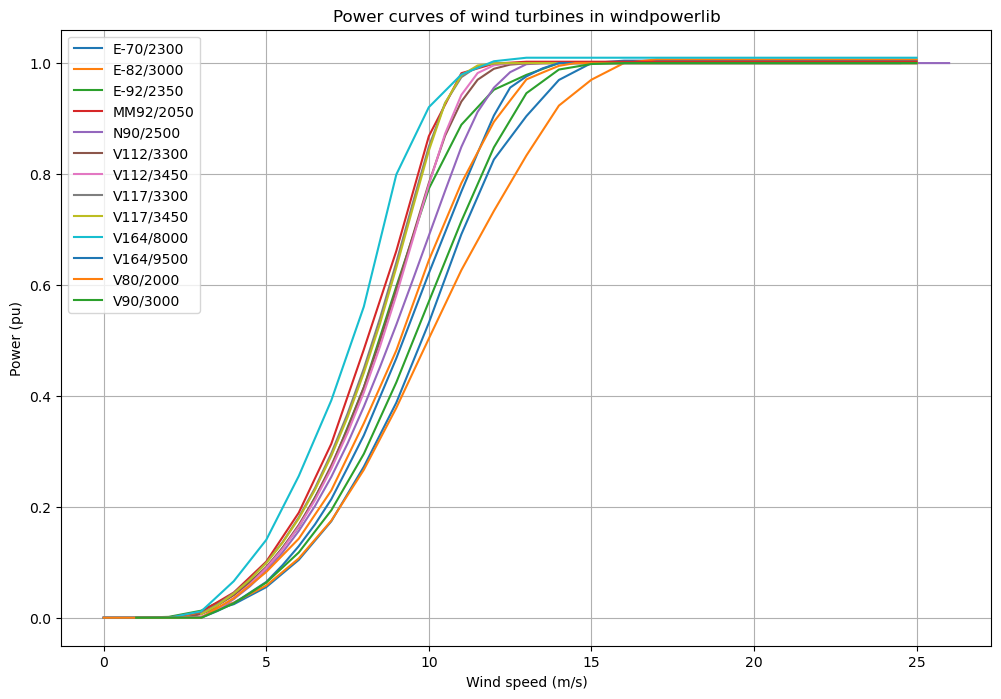

In [243]:
from windpowerlib import WindTurbine
from windpowerlib import data as wt
import matplotlib.pyplot as plt

# Turbinendaten abrufen
turbine_data = wt.get_turbine_types(print_out=False)

# Liste zum Speichern der erstellten WindTurbine-Objekte
wind_turbines = []
wind_turbines_names = []

# Schleife über alle Turbinentypen im Set
for turbine_type in unique_turbine_types_real_data:
    # Prüfen, ob der Turbinentyp in den Daten existiert
    if turbine_type in turbine_data['turbine_type'].values:
        
        hub_height = 100  # Nabenhöhe irrelevant für power curve
        
        # Definition des WindTurbine-Dictionaries
        turbine_dict = {
            'turbine_type': turbine_type,
            'hub_height': hub_height
        }
        
        # Dynamische Erstellung des WindTurbine-Objekts
        wind_turbine = WindTurbine(**turbine_dict)
        
        # Hinzufügen zur Liste
        wind_turbines.append(wind_turbine)
        wind_turbines_names.append(turbine_type)

# Plot der Power Curves
plt.figure(figsize=(12, 8))
for turbine in wind_turbines:
    if turbine.power_curve is not None:
        plt.plot(turbine.power_curve['wind_speed'], turbine.power_curve['value'] / turbine.nominal_power,
                 label=turbine.turbine_type)

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (pu)')
plt.title('Power curves of wind turbines in windpowerlib')
plt.legend()
plt.grid(True)
plt.show()

Forecasting with reanalysis data

In [244]:
from scipy.interpolate import interp1d

# After analysis of the plot
default_turbine_windpowerlib = next(turbine for turbine in wind_turbines if turbine.turbine_type == "N90/2500")
wind_speed_max = 25

prediction_3_reanalysis = []

turbine_types = combined_features_raw[:, 0]
wind_speeds_data = combined_features_raw[:, 4]
capacities = combined_features_raw[:, 2]

# Iterate over all data points
for turbine_type, wind_speed, capacity in zip(turbine_types, wind_speeds_data, capacities):

    if turbine_type in wind_turbines_names:
        turbine = wind_turbines[wind_turbines_names.index(turbine_type)]
    else:
        turbine = default_turbine_windpowerlib

    # Create an interpolation function for the Power Curve of this turbine
    interpolation_function = interp1d(
        turbine.power_curve['wind_speed'],
        turbine.power_curve['value'] / turbine.nominal_power,
        kind='cubic',
        bounds_error=False,  # Prevent out-of-bounds errors
        fill_value=0  # Set values outside the range to 0
    )

    # Calculate the predicted value
    prediction_3_reanalysis.append(interpolation_function(wind_speed))

# Convert to numpy array
prediction_3_reanalysis = np.array(prediction_3_reanalysis)

# Apply cut-off for wind speeds above the maximum cut-off speed
cut_off_speed = 25
prediction_3_reanalysis[np.array(wind_speeds_data) > cut_off_speed] = 0

Forecasting with reforecast data

In [246]:
from scipy.interpolate import interp1d

# After analysis of the plot
default_turbine_windpowerlib = next(turbine for turbine in wind_turbines if turbine.turbine_type == "N90/2500")
wind_speed_max = 25

prediction_3_reforecast = {}

for key, (combined_features, output) in dataset_lead_times.items():
    lead_time = key
    print(f"Forecasting for lead time {lead_time}")

    turbine_types = combined_features[:, 0]
    wind_speeds_data = combined_features[:, 4]
    capacities = combined_features[:, 2]

    prediction_3_lead_time = []

    # Iterate over all data points
    for turbine_type, wind_speed, capacity in zip(turbine_types, wind_speeds_data, capacities):

        if turbine_type in wind_turbines_names:
            turbine = wind_turbines[wind_turbines_names.index(turbine_type)]
        else:
            turbine = default_turbine_windpowerlib

        # Create an interpolation function for the Power Curve of this turbine
        interpolation_function = interp1d(
            turbine.power_curve['wind_speed'],
            turbine.power_curve['value'] / turbine.nominal_power,
            kind='cubic',
            bounds_error=False,  # Prevent out-of-bounds errors
            fill_value=0  # Set values outside the range to 0
        )

        # Calculate the predicted value
        prediction_3_lead_time.append(interpolation_function(wind_speed))

    # Convert to numpy array
    prediction_3_lead_time = np.array(prediction_3_lead_time)

    # Apply cut-off for wind speeds above the maximum cut-off speed
    cut_off_speed = 25
    prediction_3_lead_time[np.array(wind_speeds_data) > cut_off_speed] = 0

    prediction_3_reforecast[lead_time] = prediction_3_lead_time

Forecasting for lead time 0
Forecasting for lead time 102
Forecasting for lead time 105
Forecasting for lead time 108
Forecasting for lead time 111
Forecasting for lead time 114
Forecasting for lead time 117
Forecasting for lead time 12
Forecasting for lead time 120
Forecasting for lead time 123
Forecasting for lead time 126
Forecasting for lead time 129
Forecasting for lead time 132
Forecasting for lead time 135
Forecasting for lead time 138
Forecasting for lead time 141
Forecasting for lead time 144
Forecasting for lead time 15
Forecasting for lead time 18
Forecasting for lead time 21
Forecasting for lead time 24
Forecasting for lead time 27
Forecasting for lead time 3
Forecasting for lead time 30
Forecasting for lead time 33
Forecasting for lead time 36
Forecasting for lead time 39
Forecasting for lead time 42
Forecasting for lead time 45
Forecasting for lead time 48
Forecasting for lead time 51
Forecasting for lead time 54
Forecasting for lead time 57
Forecasting for lead time 6
Fo

<h1>4. Results

Reanalysis evaluation

In [6]:
import torch
import numpy as np
import joblib

case = 2 # choose from [1, 2, 3]
if case == 1:
    prediction_reanalysis = prediction_1_reanalysis
elif case == 2:
    prediction_reanalysis = prediction_2_reanalysis
elif case == 3:
    prediction_reanalysis = prediction_3_reanalysis

prediction_reanalysis = np.array(prediction_reanalysis, dtype=np.float32)

# convert to tensors
prediction_reanalysis = torch.tensor(prediction_reanalysis, dtype=torch.float32)
output_reanalysis = torch.tensor(output_raw, dtype=torch.float32).flatten()

huber = torch.nn.HuberLoss()
mae = torch.nn.L1Loss()
mse = torch.nn.MSELoss()

# reanalysis metrics
huber_loss_reanalysis = huber(prediction_reanalysis, output_reanalysis).item()
mae_reanalysis = mae(prediction_reanalysis, output_reanalysis).item()
mse_reanalysis = mae(prediction_reanalysis, output_reanalysis).item()
rmse_reanalysis = np.sqrt(mse_reanalysis).item()

metrics_reanalysis = {
    "Huber": huber_loss_reanalysis,
    "MAE": mae_reanalysis,
    "MSE": mse_reanalysis,
    "RMSE": rmse_reanalysis
}

joblib.dump(metrics_reanalysis, f"metrics/metrics_reanalysis_{case}.pkl")
print(f"metrics reanalysis saved")

metrics reanalysis saved


Reforecast evaluation

In [ ]:
import torch
import numpy as np
import joblib

case = 2 # choose from [1, 2, 3]
if case == 1:
    prediction_reforecast = prediction_1_reforecast
elif case == 2:
    prediction_reforecast = prediction_2_reforecast
elif case == 3:
    prediction_reforecast = prediction_3_reforecast

# reforecast metrics
metrics_reforecast = {}
for ((key1, prediction), (key2, (combined_features, output))) in zip(prediction_reforecast.items(), dataset_lead_times.items()):

    assert key1 == key2
    lead_time = key1
    print(f"Testing for lead time {lead_time}")

    prediction = torch.tensor(prediction, dtype=torch.float32)
    output = np.array(output, dtype=np.float32)
    output = torch.tensor(output, dtype=torch.float32).flatten()

    huber_loss_reforecast = huber(prediction, output).item()
    mae_reforecast = mae(prediction, output).item()
    mse_reforecast = mae(prediction, output).item()
    rmse_reforecast = np.sqrt(mse_reforecast).item()

    metrics_reforecast[lead_time] = {
        "Huber": huber_loss_reforecast,
        "MAE": mae_reforecast,
        "MSE": mse_reforecast,
        "RMSE": rmse_reforecast
    }


joblib.dump(metrics_reforecast, f"metrics/metrics_reforecast_{case}.pkl")
print(f"metrics reforecast saved")

<h1>Henceforth only reforecast investigation

Histograms with error distributions

c:\Users\alexa\anaconda3\envs\webapp_env_conda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


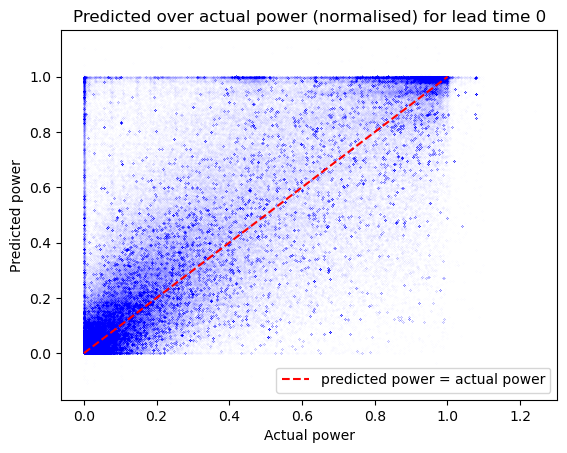

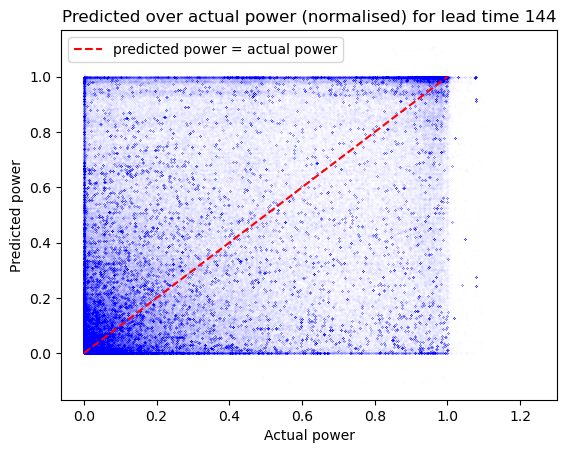

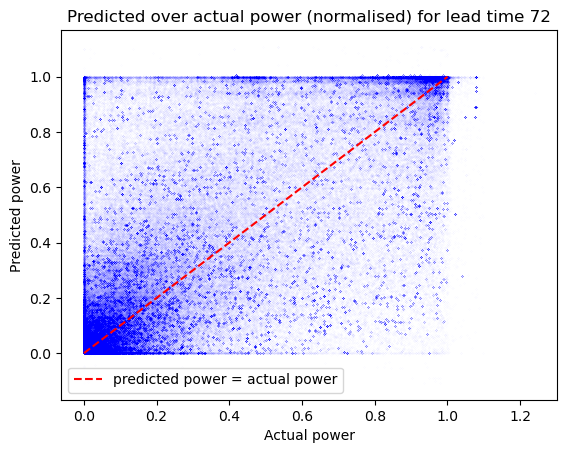

In [ ]:
import numpy as np

case = 2 # choose from [1, 2, 3]
if case == 1:
    prediction_reforecast = prediction_1_reforecast
elif case == 2:
    prediction_reforecast = prediction_2_reforecast
elif case == 3:
    prediction_reforecast = prediction_3_reforecast

histogram_data = {}

for ((key1, prediction), (key2, (combined_features, output))) in zip(prediction_reforecast.items(), dataset_lead_times.items()):

    assert key1 == key2
    lead_time = key1

    if key1 == 0 or key1 == 72 or key1 == 144:

        histogram_data[key1] = {}

        absolute_errors = np.array(output - prediction.reshape(-1, 1))
        relative_errors = np.array(absolute_errors / (output + 1e-8))

        mean_abs_error = np.mean(absolute_errors)
        std_abs_error = np.std(absolute_errors)

        mean_rel_error = np.mean(relative_errors)
        std_rel_error = np.std(relative_errors)

        histogram_data[key1] = {
            "absolute_errors": absolute_errors,
            "relative_errors": relative_errors,
            "mean_abs_error": mean_abs_error,
            "std_abs_error": std_abs_error,
            "mean_rel_error": mean_rel_error,
            "std_rel_error": std_rel_error
        }

        plt.figure()
        plt.scatter(output, prediction, color="blue", s=0.001/5, alpha=0.5) # divide point thickness by 5 to consider that the analogous plot for model C was created on only 1 5th of the total dat amount (the testing data)
        plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="predicted power = actual power")
        plt.title(f"Predicted over actual power (normalised) for lead time {key1}")
        plt.xlabel("Actual power")
        plt.ylabel("Predicted power")
        plt.legend()
        plt.show()

Round to 3 significant digits

In [12]:
def round_to_significant(x, sig_digits=3):
    if x == 0:
        return "0"  # Avoid log10(0) error
    return f"{x:.{sig_digits}g}"  # Format as a string with significant digits

Absolute errors

1) Confirm that for intermediate lead times the histograms are a proportionate mixture of the ones for extreme lead times

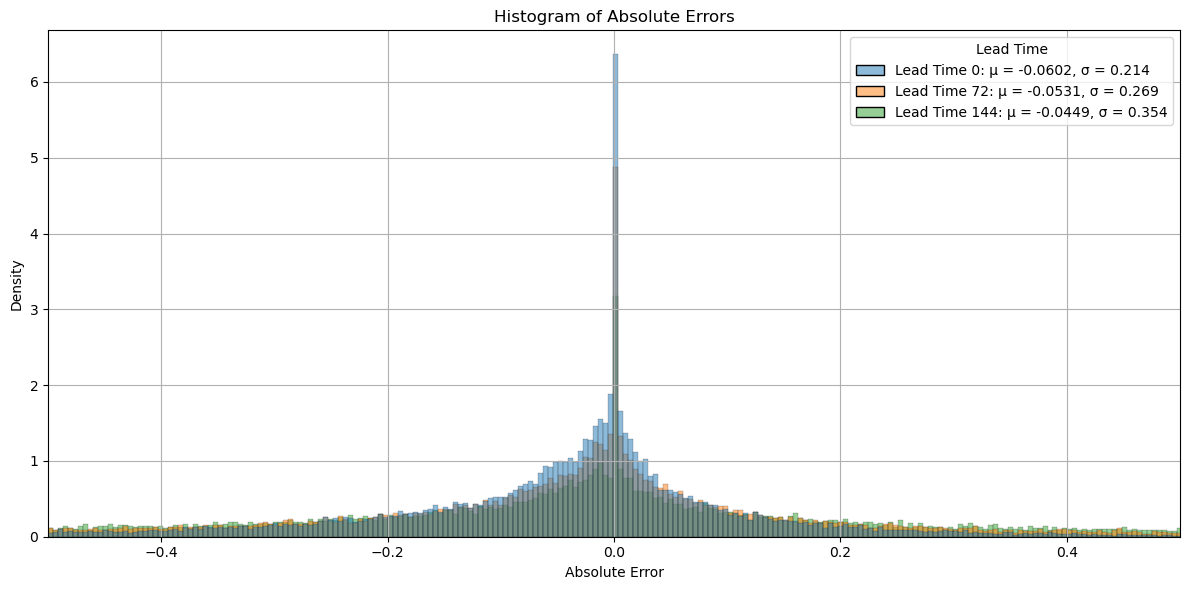

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


errors_abs_0 = np.array(histogram_data[0]["absolute_errors"]).flatten()
errors_abs_72 = np.array(histogram_data[72]["absolute_errors"]).flatten()
errors_abs_144 = np.array(histogram_data[144]["absolute_errors"]).flatten()
µ_abs_0 = round_to_significant(histogram_data[0]["mean_abs_error"])
µ_abs_72 = round_to_significant(histogram_data[72]["mean_abs_error"])
µ_abs_144 = round_to_significant(histogram_data[144]["mean_abs_error"])
σ_abs_0 = round_to_significant(histogram_data[0]["std_abs_error"])
σ_abs_72 = round_to_significant(histogram_data[72]["std_abs_error"])
σ_abs_144 = round_to_significant(histogram_data[144]["std_abs_error"])

# Create a DataFrame
df_errors_abs = pd.DataFrame({
    "Absolute Error": np.concatenate([errors_abs_0, errors_abs_72, errors_abs_144]),
    "Lead Time": np.repeat([f"Lead Time 0: µ = {µ_abs_0}, σ = {σ_abs_0}", f"Lead Time 72: µ = {µ_abs_72}, σ = {σ_abs_72}", f"Lead Time 144: µ = {µ_abs_144}, σ = {σ_abs_144}"], [len(errors_abs_0), len(errors_abs_72), len(errors_abs_144)])
})

# Plot using Seaborn with hue
plt.figure(figsize=(12, 6))
sns.histplot(data=df_errors_abs, x="Absolute Error", hue="Lead Time", bins=500, alpha=0.5, kde=False, stat="density")

# Titles and labels
plt.title("Histogram of Absolute Errors")
plt.xlabel("Absolute Error")
plt.ylabel("Density")
plt.xlim(-0.5, 0.5)
plt.grid(True)
plt.tight_layout()
plt.show()

2) For thesis only the histograms at extreme lead times

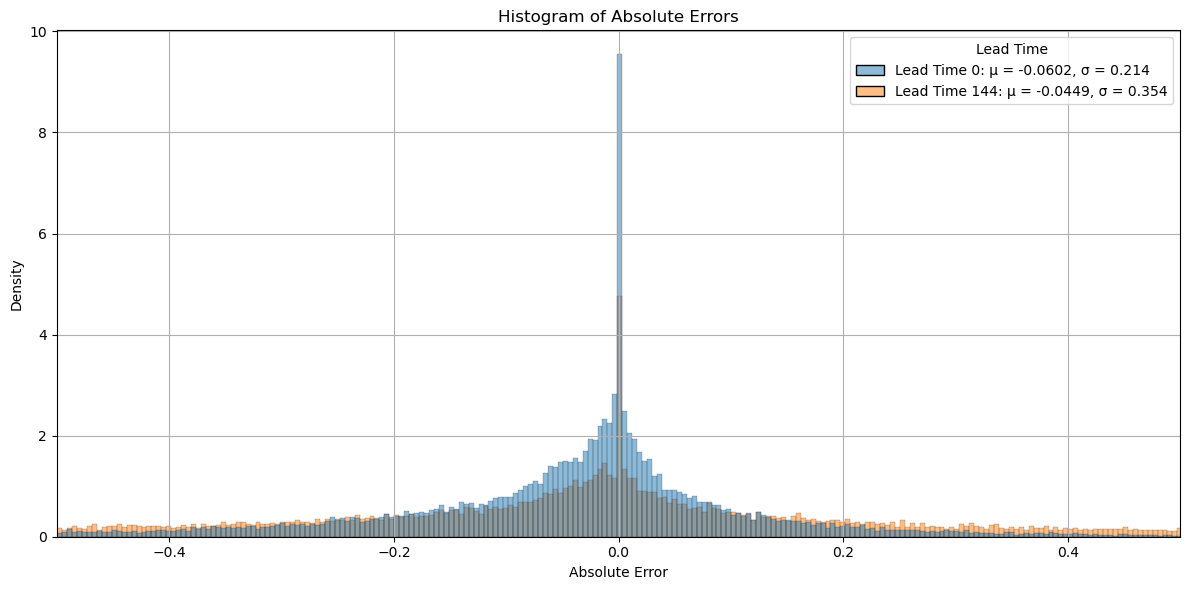

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


errors_abs_0 = np.array(histogram_data[0]["absolute_errors"]).flatten()
errors_abs_144 = np.array(histogram_data[144]["absolute_errors"]).flatten()
µ_abs_0 = round_to_significant(histogram_data[0]["mean_abs_error"])
µ_abs_144 = round_to_significant(histogram_data[144]["mean_abs_error"])
σ_abs_0 = round_to_significant(histogram_data[0]["std_abs_error"])
σ_abs_144 = round_to_significant(histogram_data[144]["std_abs_error"])

# Create a DataFrame
df_errors_abs = pd.DataFrame({
    "Absolute Error": np.concatenate([errors_abs_0, errors_abs_144]),
    "Lead Time": np.repeat([f"Lead Time 0: µ = {µ_abs_0}, σ = {σ_abs_0}", f"Lead Time 144: µ = {µ_abs_144}, σ = {σ_abs_144}"], [len(errors_abs_0), len(errors_abs_144)])
})

# Plot using Seaborn with hue
plt.figure(figsize=(12, 6))
sns.histplot(data=df_errors_abs, x="Absolute Error", hue="Lead Time", bins=500, alpha=0.5, kde=False, stat="density")

# Titles and labels
plt.title("Histogram of Absolute Errors")
plt.xlabel("Absolute Error")
plt.ylabel("Density")
plt.xlim(-0.5, 0.5)
plt.grid(True)
plt.tight_layout()
plt.show()

Relative errors

1) Confirm that for intermediate lead times the histograms are a proportionate mixture of the ones for extreme lead times

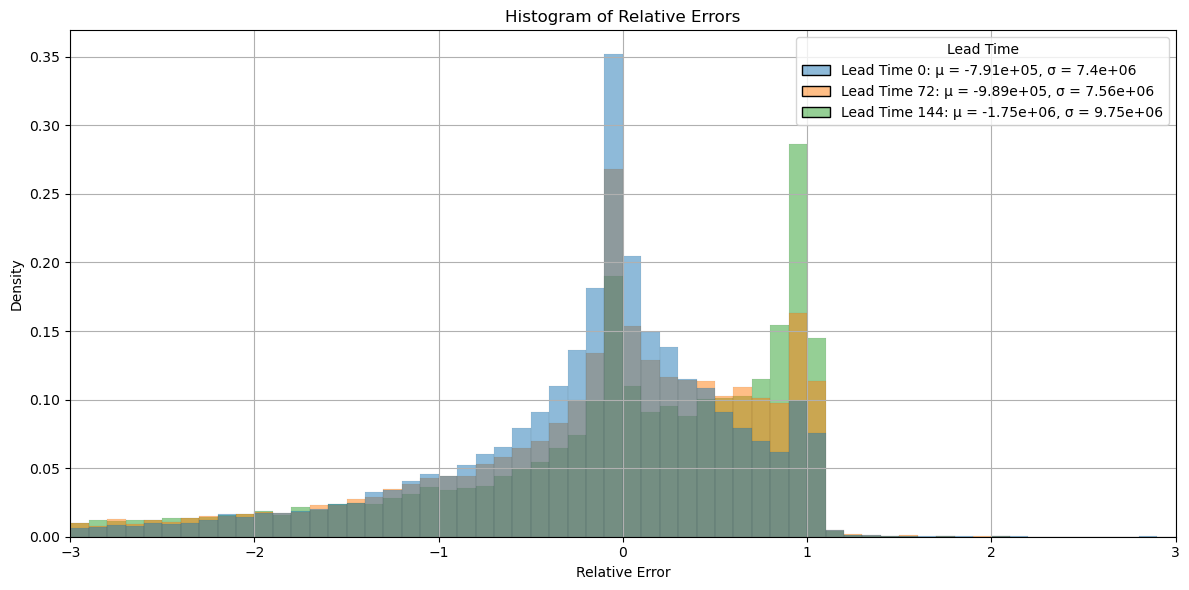

In [17]:
errors_rel_0 = np.array(histogram_data[0]["relative_errors"]).flatten()
errors_rel_72 = np.array(histogram_data[72]["relative_errors"]).flatten()
errors_rel_144 = np.array(histogram_data[144]["relative_errors"]).flatten()
µ_rel_0 = round_to_significant(histogram_data[0]["mean_rel_error"])
µ_rel_72 = round_to_significant(histogram_data[72]["mean_rel_error"])
µ_rel_144 = round_to_significant(histogram_data[144]["mean_rel_error"])
σ_rel_0 = round_to_significant(histogram_data[0]["std_rel_error"])
σ_rel_72 = round_to_significant(histogram_data[72]["std_rel_error"])
σ_rel_144 = round_to_significant(histogram_data[144]["std_rel_error"])

# otherwise no meaningful representation possible
errors_rel_0 = np.clip(errors_rel_0, -100, 100)
errors_rel_72 = np.clip(errors_rel_72, -100, 100)
errors_rel_144 = np.clip(errors_rel_144, -100, 100)

# Create a DataFrame
df_errors_rel = pd.DataFrame({
    "Relative Error": np.concatenate([errors_rel_0, errors_rel_72, errors_rel_144]),
    "Lead Time": np.repeat([f"Lead Time 0: µ = {µ_rel_0}, σ = {σ_rel_0}", f"Lead Time 72: µ = {µ_rel_72}, σ = {σ_rel_72}", f"Lead Time 144: µ = {µ_rel_144}, σ = {σ_rel_144}"], [len(errors_rel_0), len(errors_rel_72), len(errors_rel_144)])
})

# Plot using Seaborn with hue
plt.figure(figsize=(12, 6))
sns.histplot(data=df_errors_rel, x="Relative Error", hue="Lead Time", bins=2000, alpha=0.5, kde=False, stat="density")

# Titles and labels
plt.title("Histogram of Relative Errors")
plt.xlabel("Relative Error")
plt.ylabel("Density")
plt.xlim(-3, 3)
plt.grid(True)
plt.tight_layout()
plt.show()

2) For thesis only the histograms at extreme lead times

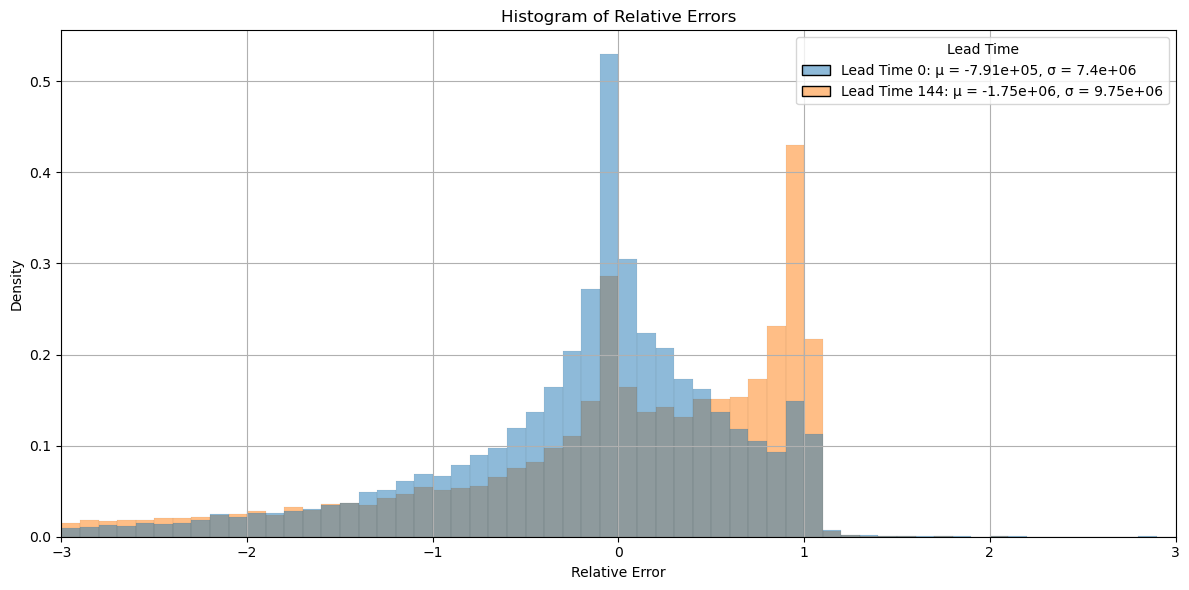

In [ ]:
errors_rel_0 = np.array(histogram_data[0]["relative_errors"]).flatten()
errors_rel_144 = np.array(histogram_data[144]["relative_errors"]).flatten()
µ_rel_0 = round_to_significant(histogram_data[0]["mean_rel_error"])
µ_rel_144 = round_to_significant(histogram_data[144]["mean_rel_error"])
σ_rel_0 = round_to_significant(histogram_data[0]["std_rel_error"])
σ_rel_144 = round_to_significant(histogram_data[144]["std_rel_error"])

# otherwise no meaningful representation possible
errors_rel_0 = np.clip(errors_rel_0, -100, 100)
errors_rel_144 = np.clip(errors_rel_144, -100, 100)

# Create a DataFrame
df_errors_rel = pd.DataFrame({
    "Relative Error": np.concatenate([errors_rel_0, errors_rel_144]),
    "Lead Time": np.repeat([f"Lead Time 0: µ = {µ_rel_0}, σ = {σ_rel_0}", f"Lead Time 144: µ = {µ_rel_144}, σ = {σ_rel_144}"], [len(errors_rel_0), len(errors_rel_144)])
})

# Plot using Seaborn with hue
plt.figure(figsize=(12, 6))
sns.histplot(data=df_errors_rel, x="Relative Error", hue="Lead Time", bins=2000, alpha=0.5, kde=False, stat="density")

# Titles and labels
plt.title("Histogram of Relative Errors")
plt.xlabel("Relative Error")
plt.ylabel("Density")
plt.xlim(-3, 3)
plt.grid(True)
plt.tight_layout()
plt.show()

Further creative structures

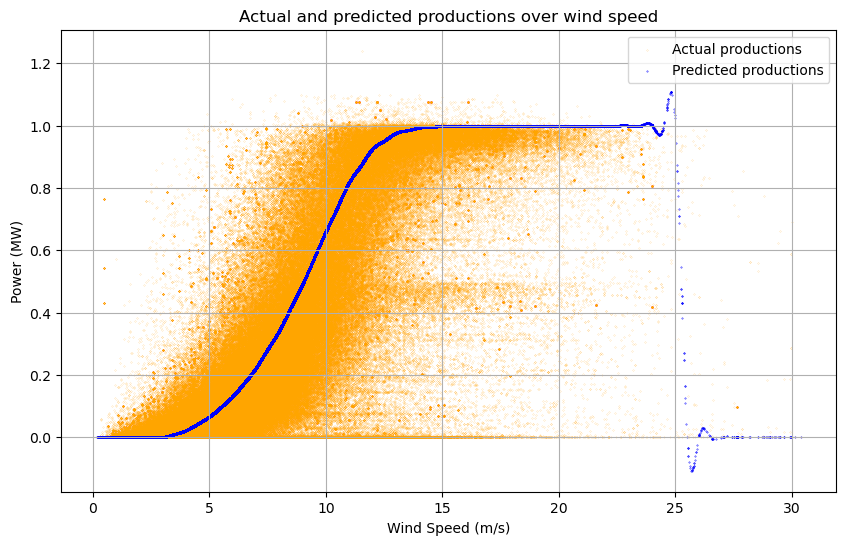

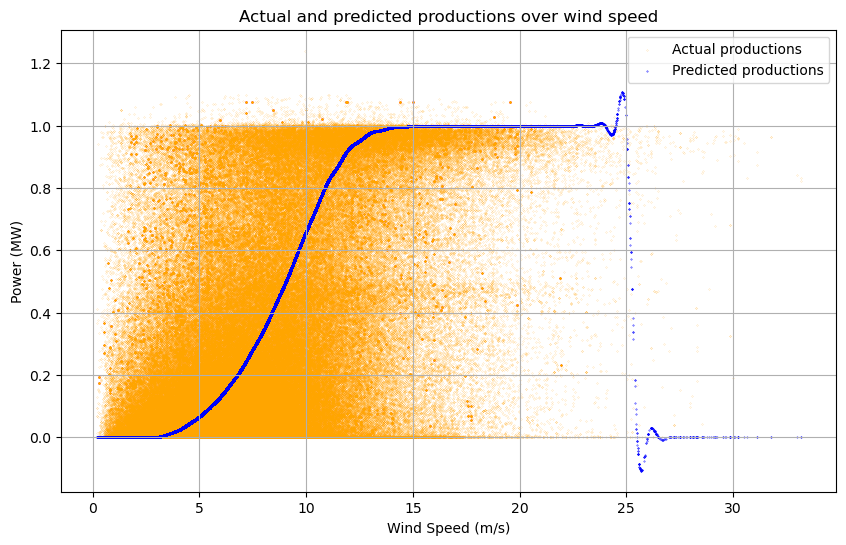

In [53]:
import matplotlib.pyplot as plt

for ((key1, prediction), (key2, (combined_features, output))) in zip(prediction_reforecast.items(), dataset_lead_times.items()):

    assert key1 == key2
    lead_time = key1

    if key1 == 0 or key1 == 144:

        wind_speeds_data = combined_features[:, -1]

        plt.figure(figsize=(10, 6))
        plt.scatter(wind_speeds_data, output, color='orange', s=0.01, label='Actual productions')
        plt.scatter(wind_speeds_data, prediction, color='blue', s=0.1, label='Predicted productions')
        plt.xlabel('Wind Speed (m/s)')
        plt.ylabel('Power (MW)')
        plt.title('Actual and predicted productions over wind speed')
        plt.legend()
        plt.grid(True)
        plt.show()

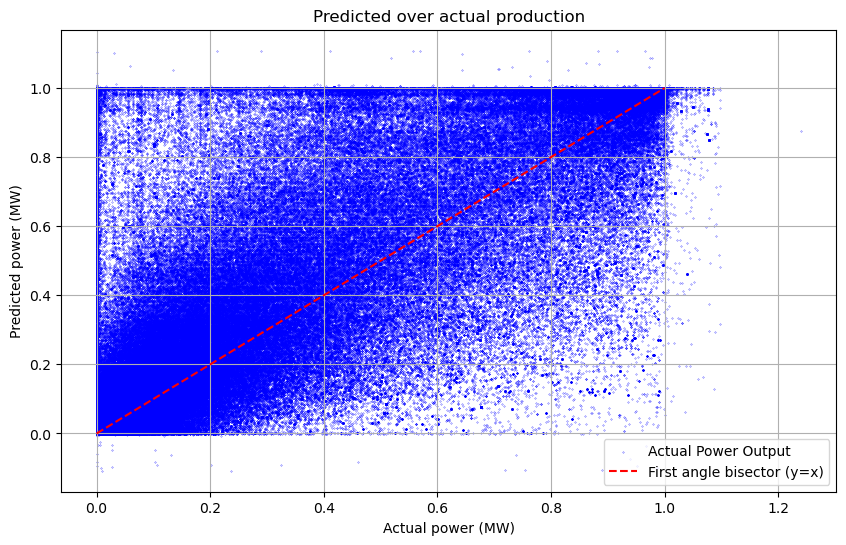

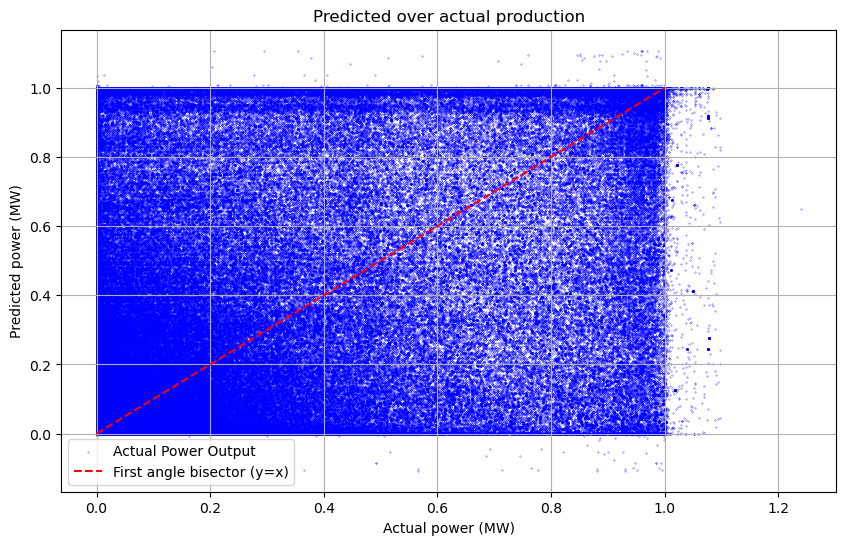

In [ ]:
import matplotlib.pyplot as plt

for ((key1, prediction), (key2, (combined_features, output))) in zip(prediction_reforecast.items(), dataset_lead_times.items()):

    assert key1 == key2
    lead_time = key1

    if key1 == 0 or key1 == 144:

        wind_speeds_data = combined_features[:, -1]

        plt.figure(figsize=(10, 6))
        plt.scatter(output, prediction, color='blue', s=0.001, label='Actual Power Output')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='First angle bisector (y=x)')
        plt.xlabel('Actual power (MW)')
        plt.ylabel('Predicted power (MW)')
        plt.title('Predicted over actual production')
        plt.legend()
        plt.grid(True)
        plt.show()

C:\Users\alexa\AppData\Local\Temp\ipykernel_11480\629658139.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


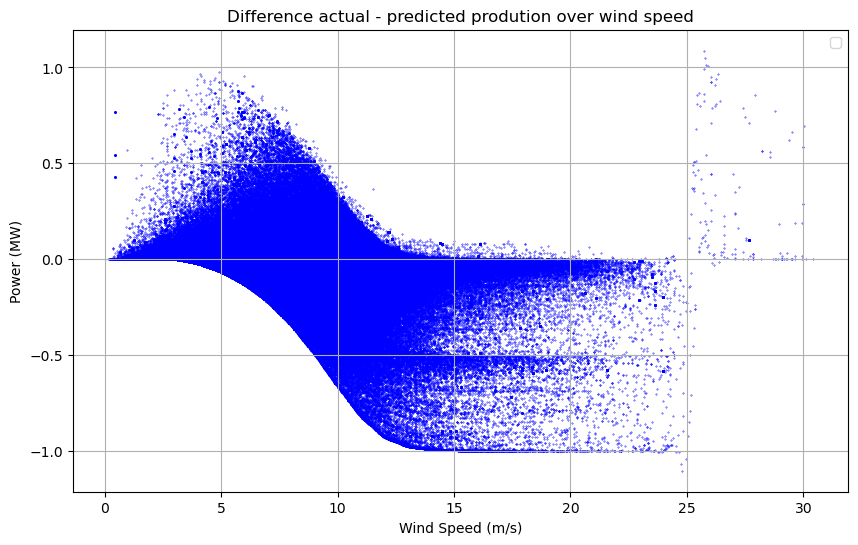

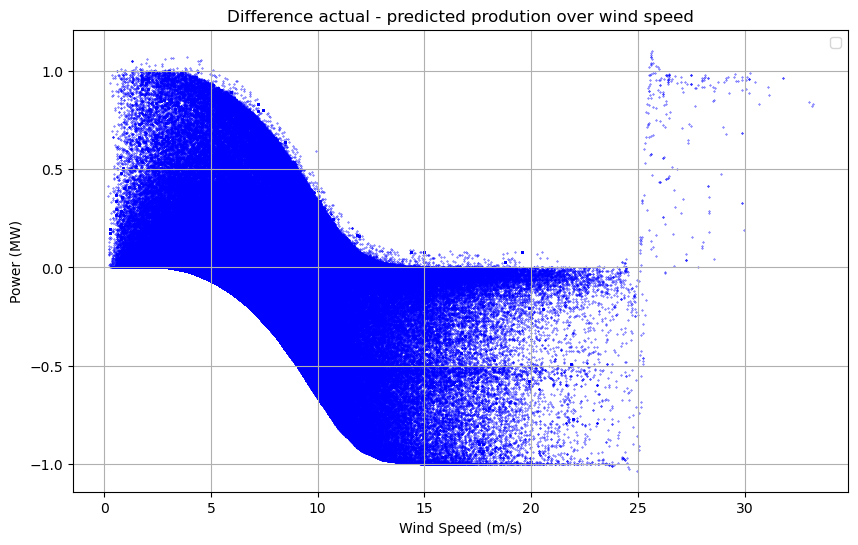

In [72]:
import matplotlib.pyplot as plt

for ((key1, prediction), (key2, (combined_features, output))) in zip(prediction_reforecast.items(), dataset_lead_times.items()):

    assert key1 == key2
    lead_time = key1

    if key1 == 0 or key1 == 144:

        wind_speeds_data = combined_features[:, -1]

        plt.figure(figsize=(10, 6))
        plt.scatter(wind_speeds_data, output-prediction.reshape(-1, 1), color='blue', s=0.1)
        plt.xlabel('Wind Speed (m/s)')
        plt.ylabel('Power (MW)')
        plt.title('Difference actual - predicted prodution over wind speed')
        plt.legend()
        plt.grid(True)
        plt.show()

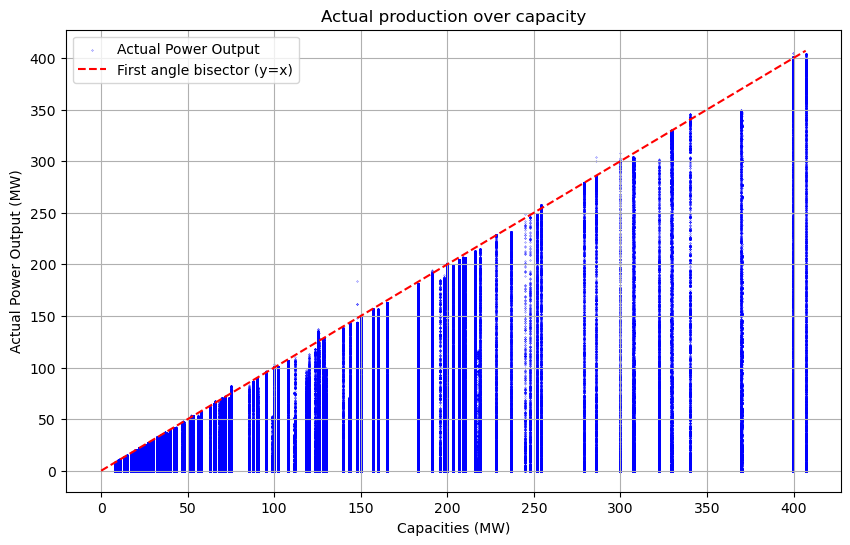

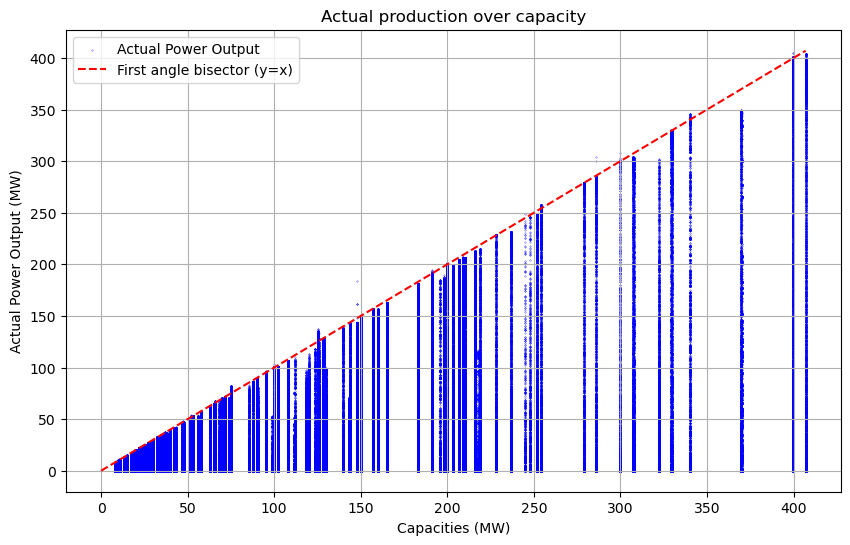

In [70]:
import matplotlib.pyplot as plt

for ((key1, prediction), (key2, (combined_features, output))) in zip(prediction_reforecast.items(), dataset_lead_times.items()):

    assert key1 == key2
    lead_time = key1

    if key1 == 0 or key1 == 144:

        capacities = combined_features[:, -3]

        plt.figure(figsize=(10, 6))
        plt.scatter(capacities, output*capacities.reshape(-1, 1), color='blue', s=0.05, label='Actual Power Output')
        plt.plot([0, max(capacities)], [0, max(capacities)], color='red', linestyle='--', label='First angle bisector (y=x)')
        plt.xlabel('Capacities (MW)')
        plt.ylabel('Actual Power Output (MW)')
        plt.title('Actual production over capacity')
        plt.legend()
        plt.grid(True)
        plt.show()